# getting number of clusters louvain + gmm

In [1]:
import scanpy as sc
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [2]:
dataset = ''

In [3]:
# Parameters
dataset = "Lung"


In [4]:

batch_key_dic = {'Immune_Human' : 'batch',
                 'Lung' : 'batch',
                 'Pancreas' : 'tech',
                 'Human_Mouse' : 'batch',
                 'Human_Retina': "Batch",
                 
                }
cell_type_key_dic = {'Immune_Human' : 'final_annotation',
                 'Lung' : 'cell_type',
                 'Pancreas' : 'celltype',
                 'Human_Mouse' : "celltype",
                 "Human_Retina":"Subcluster",
                    }    

dir_path = "/home/krushna/Documents/Data_integration/SCRNA_Datasets/All_h5ad/"
emb_path = "/home/krushna/Documents/Data_integration/Othermethods/ourmethod/self-sup/pipeline_tf2 50/step1/"
batch = batch_key_dic[dataset]
cell_type = cell_type_key_dic[dataset]

In [5]:
adata = sc.read_h5ad(dir_path+dataset+'.h5ad')
emb_path = emb_path + dataset+'_latent_matrix_c99_step1.csv'
final_embedings=pd.read_csv(emb_path, sep=',',header=None).values
adata.obsm['final_embeddings'] = final_embedings
sc.pp.neighbors(adata, use_rep='final_embeddings')
adata

/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    uns: 'neighbors'
    obsm: 'final_embeddings'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [6]:
number_of_celltypes = len(adata.obs[cell_type].unique())
print('number of cell types ',  number_of_celltypes)

number of cell types  17


In [7]:
cluster_res = []
for res in list(np.linspace(0.0001, 1.5, num=20)):
    #find clusters
    sc.tl.leiden(adata, resolution=res) # louvain
    noofclus = len(np.unique(adata.obs['leiden']))
    cluster_res.append([noofclus,res])

In [8]:
cluster_res

[[1, 0.0001],
 [7, 0.0790421052631579],
 [10, 0.15798421052631578],
 [11, 0.23692631578947368],
 [12, 0.3158684210526316],
 [13, 0.3948105263157895],
 [16, 0.47375263157894737],
 [17, 0.5526947368421052],
 [17, 0.6316368421052632],
 [18, 0.7105789473684211],
 [18, 0.789521052631579],
 [20, 0.8684631578947368],
 [20, 0.9474052631578948],
 [21, 1.0263473684210527],
 [21, 1.1052894736842105],
 [21, 1.1842315789473685],
 [23, 1.2631736842105263],
 [25, 1.3421157894736842],
 [23, 1.4210578947368422],
 [26, 1.5]]

In [9]:
# find clusters
clusters = []
sil_scores = []
ch_scores = []
bic_scores = []
db_scores = []
for res in list(np.linspace(0.0001, 1.5, num=20)):
    #find clusters
    sc.tl.leiden(adata, resolution=res) # louvain
    noofclus = len(np.unique(adata.obs['leiden']))
    
    if noofclus == 1:
        continue
        
    clusters.append(noofclus)
    # silhouette_score
    sil_score = silhouette_score(adata.obsm['final_embeddings'], adata.obs['leiden'])
    sil_scores.append(sil_score)
    
    #ch score
    ch = calinski_harabasz_score(adata.obsm['final_embeddings'], adata.obs['leiden'])
    ch_scores.append(ch)
    
    #db scores
    db = davies_bouldin_score(adata.obsm['final_embeddings'], adata.obs['leiden'])
    db_scores.append(db)
    
    # bic 
    gmm = GaussianMixture(n_components=noofclus).fit(adata.obsm['final_embeddings'])
    labels = gmm.predict(adata.obsm['final_embeddings'])
    bic = gmm.bic(adata.obsm['final_embeddings'])
    bic_scores.append(bic)

In [10]:
pd.DataFrame([clusters,ch_scores,sil_scores, bic_scores, db_scores])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,7.000000,10.000000,11.000000,12.000000,13.000000,16.000000,17.000000,17.000000,18.000000,18.000000,20.000000,20.000000,21.000000,21.000000,21.000000,23.000000,25.000000,23.000000,26.000000
1,8033.426823,7056.706726,7835.564753,7766.678638,7635.952466,7013.122468,6733.865949,6751.893967,6361.398102,6376.403808,6207.242827,6235.502355,5992.392848,5960.961138,6075.220168,5754.707703,5493.003015,5765.687407,5283.621049
2,0.342542,0.349957,0.331955,0.339512,0.334004,0.317700,0.295500,0.295321,0.272987,0.274058,0.260666,0.267607,0.256498,0.253737,0.258275,0.247577,0.233133,0.248396,0.226594
3,866187.643641,848232.336779,842897.172093,833840.290545,836546.868975,830991.145902,827340.717021,821355.979533,820759.521849,826713.983431,820491.453433,819287.342837,819051.539895,820171.022634,820304.078995,817713.267997,817291.580742,818217.292017,816317.128161
4,1.156266,0.951192,1.023723,1.034892,1.172465,1.166892,1.190208,1.192707,1.239289,1.238109,1.279444,1.255863,1.290431,1.298442,1.315790,1.321321,1.420743,1.322473,1.446556


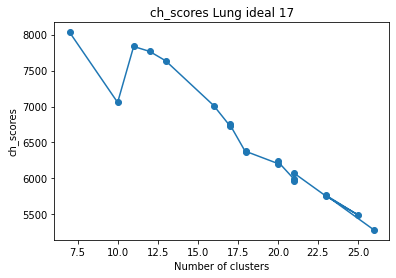

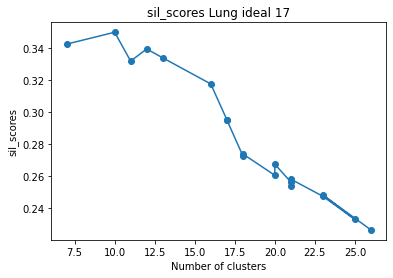

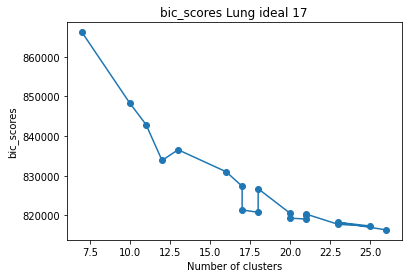

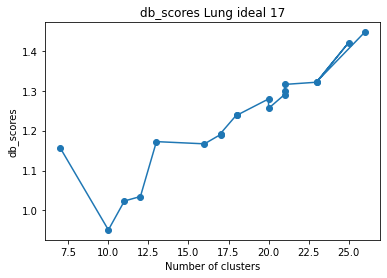

In [11]:
plt.plot(clusters, ch_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('ch_scores')
plt.title('ch_scores '+dataset+' ideal '+ str(number_of_celltypes))
plt.show()

plt.plot(clusters, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('sil_scores')
plt.title('sil_scores '+dataset+' ideal '+ str(number_of_celltypes))
plt.show()

plt.plot(clusters, bic_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('bic_scores')
plt.title('bic_scores '+dataset+' ideal '+ str(number_of_celltypes))
plt.show()

plt.plot(clusters, db_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('db_scores')
plt.title('db_scores '+dataset+' ideal '+ str(number_of_celltypes))
plt.show()

<ipython-input-12-d3a8007b4db6>:5: RuntimeWarning: divide by zero encountered in double_scalars
  slope = (y2-y1)/(x2-x1)


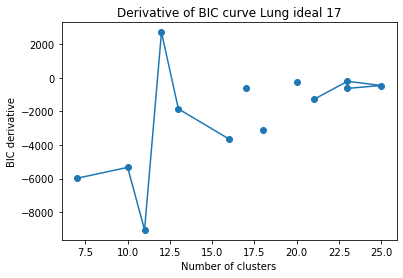

In [12]:
slopes = []
for i in range(len(clusters)-1):
    x1, x2 = clusters[i], clusters[i+1]
    y1, y2 = bic_scores[i], bic_scores[i+1]
    slope = (y2-y1)/(x2-x1)
    slopes.append(slope)
    
# bic_deriv = np.gradient(bics, clusters)

# plot derivative of BIC curve
plt.plot(clusters[:-1], slopes, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC derivative')
plt.title('Derivative of BIC curve '+ dataset +' ideal ' + str(number_of_celltypes) )
plt.show()
    

In [13]:
# bic_deriv = np.gradient(bics, clusters)

# # plot derivative of BIC curve
# plt.plot(clusters, bic_deriv, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('BIC derivative')
# plt.title('Derivative of BIC curve')
# plt.show()